In [1]:
from PIL import Image
import numpy as np
import os
import torch
from diffusers import DDIMScheduler,StableDiffusionXLPipeline,StableDiffusionXLInpaintPipeline
from diffusers.utils import load_image
from torchvision.io import read_image, ImageReadMode
from masactrl.masactrl import MutualSelfAttentionControlMask_An_aug_XL
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import torch.nn.functional as F
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms.functional import gaussian_blur
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-05 13:47:04.669278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 13:47:05.878711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
#scheduler = DPMSolverMultistepScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",solver_order=3)
base = StableDiffusionXLInpaintPipeline.from_pretrained(
    "/hy-tmp/stable-diffusion-xl-base-1.0",
    custom_pipeline="/hy-tmp/MyREMOVAL/SDXL_inp_pipeline.py",
    scheduler=scheduler,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to(device)

""" 
refiner = StableDiffusionXLInpaintPipeline.from_pretrained(
    "/hy-tmp/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    scheduler=scheduler,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to(device) """


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


' \nrefiner = StableDiffusionXLInpaintPipeline.from_pretrained(\n    "/hy-tmp/stable-diffusion-xl-refiner-1.0",\n    text_encoder_2=base.text_encoder_2,\n    scheduler=scheduler,\n    vae=base.vae,\n    torch_dtype=torch.float16,\n    use_safetensors=True,\n    variant="fp16",\n).to(device) '

In [3]:
seed=776
g = torch.Generator('cuda').manual_seed(seed)
def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (1024, 1024))
    image = image.to(torch.float16).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (1024, 1024))
    mask = gaussian_blur(mask, kernel_size=(13, 13))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(torch.float16).to(device)
    return mask


sample = "m_1024"
out_dir = f"./workdir/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
#SOURCE_IMAGE_PATH = "/hy-tmp/MyREMOVAL/result.png"
#SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
#MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
SOURCE_IMAGE_PATH = "/hy-tmp/DATA/test_sample0/9e5160657896fa20_m0pcr_75e78068.jpg"
MASK_PATH = "/hy-tmp/DATA/test_sample0/9e5160657896fa20_m0pcr_75e78068_mask.png"
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask = load_mask(MASK_PATH, device)

In [4]:
source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
with torch.no_grad():
    # invert the source image
    latents, start_latents = base.invert(
                                source_image,
                                source_prompt,
                                guidance_scale=1,
                                num_inference_steps=50,
                                return_intermediates=False)

DDIM Inversion: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


In [5]:
# inference the synthesized image with MasaCtrl
START_STEP = 0
END_STEP = 50
LAYER = 34 #0~23down,24~33mid,34~69up
END_LAYER = 70

# hijack the attention module
editor = MutualSelfAttentionControlMask_An_aug_XL(START_STEP, END_STEP, LAYER, END_LAYER, mask=mask,model_type="SDXL")
regiter_attention_editor_diffusers(base, editor)

In [6]:
latents = latents.expand(len(prompts), -1, -1, -1)
image = base(
    prompt=prompts,
    latents = latents,
    image=source_image,
    height=1024,
    width=1024,
    strength=1,
    mask_image=mask,
    generator=g,
    num_inference_steps=50,
    guidance_scale=1,
    output_type='pt'
).images[0]


/usr/local/miniconda3/lib/python3.8/site-packages/diffusers/image_processor.py:542: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Syntheiszed images are saved in ./workdir/m_1024/sample_8


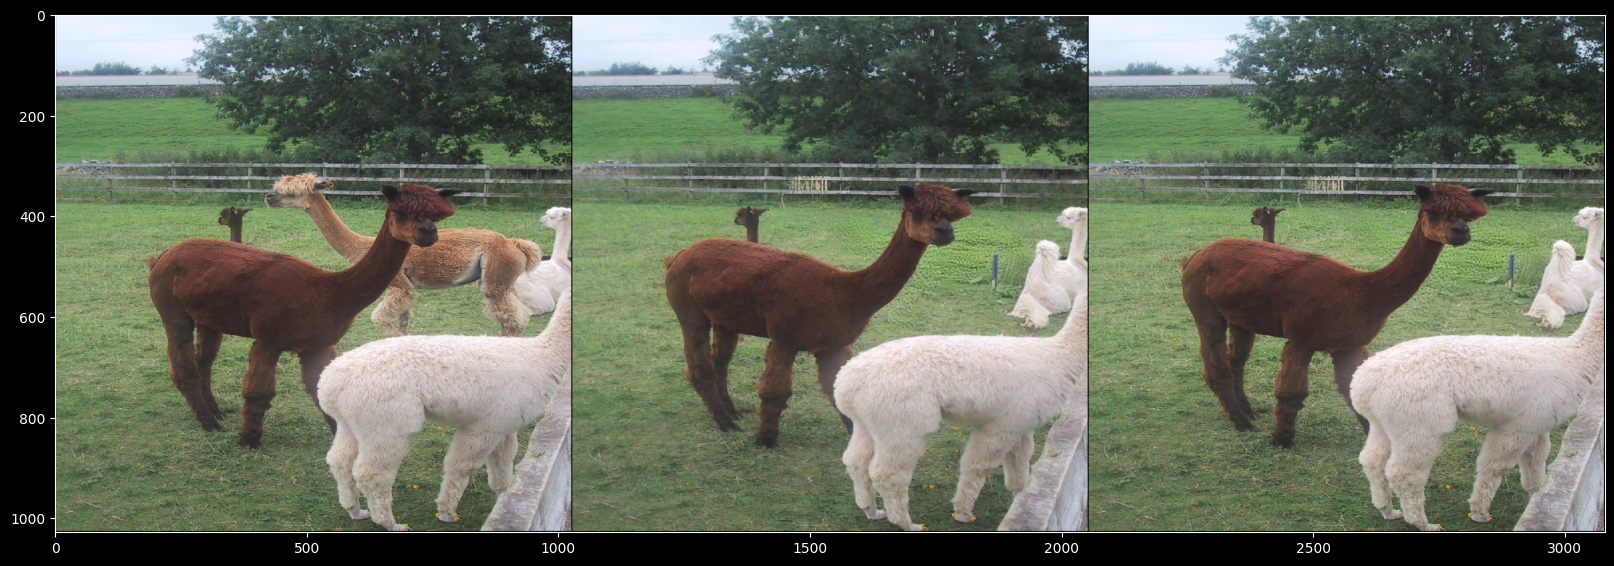

In [7]:
image=image.unsqueeze(0)
out_tile = mask * image + (1 - mask) * (source_image* 0.5 + 0.5)
out_image = torch.concat([source_image* 0.5 + 0.5,
                         image,
                         out_tile],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 26))
plt.imshow(img_ori)

In [8]:
""" prompt=""
num_inference_steps = 50
high_noise_frac = 0.8
image = base(
    prompt=prompt,
    latents = latents,
    image=source_image,
    height=1024,
    width=1024,
    strength=1,
    mask_image=mask,
    generator=g,
    num_inference_steps=num_inference_steps,
    denoising_end = high_noise_frac,
    guidance_scale=1,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    image=image,
    mask_image=mask,
    generator=g,
    num_inference_steps=num_inference_steps,
    denoising_start=high_noise_frac,
).images[0]
image.save("/hy-tmp/MyREMOVAL/result_refine.png")
image """

' prompt=""\nnum_inference_steps = 50\nhigh_noise_frac = 0.8\nimage = base(\n    prompt=prompt,\n    latents = latents,\n    image=source_image,\n    height=1024,\n    width=1024,\n    strength=1,\n    mask_image=mask,\n    generator=g,\n    num_inference_steps=num_inference_steps,\n    denoising_end = high_noise_frac,\n    guidance_scale=1,\n    output_type="latent",\n).images\n\nimage = refiner(\n    prompt=prompt,\n    image=image,\n    mask_image=mask,\n    generator=g,\n    num_inference_steps=num_inference_steps,\n    denoising_start=high_noise_frac,\n).images[0]\nimage.save("/hy-tmp/MyREMOVAL/result_refine.png")\nimage '